# Regression Modelling Superconductivity Critical Temperature from Elemental Composition

In [84]:
# Base imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

# Pipeline and Modelling
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler # including minmax feels redundant to maxabs, but leaving it out seems equally pointless
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, BayesianRidge, ARDRegression, SGDRegressor, OrthogonalMatchingPursuitCV # SDGRegressor should give same results as LinearSVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

# Plot styles
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['font.size'] = 11
from matplotlib.ticker import FuncFormatter

In [85]:
# Setting up same dataframes as EDA file
df = pd.read_csv('data/train.csv') # df happens to stand for derived features as well as data frame
chemcomp = pd.read_csv('data/unique_m.csv') # table of stoichiometric composition 
norm_chemcomp = chemcomp.drop(columns=['critical_temp','material','He','Ne','Ar','Kr','Xe','Pm','Po','At','Rn'])
norm_chemcomp = norm_chemcomp.div(norm_chemcomp.sum(axis=1),axis=0) # getting normalized compositions 


## Context from Exploratory Data Analysis
In our analysis, we noted high correlation between features derived from elemental properties, both weighted for stoichiometric proportion and not, and our target, the critical temperature (Tc) for superconduction. However we also noted high correlation between overall sample compositions and Tc, possibly largely influenced by the prevalence of barium cuprous oxides (*BaCO) superconductors in high-temperature superconduction research. Our task is then to ensure that our derived features create a better model than one derived from composition alone and the Tc is well-predicted for the full range of available temperatures and is not overfit to our *BaCO high Tc materials - that our features are meaningful APART from whether they typify a barium cuprous oxide. 

Per the original 2018 paper, I expect XGBRegressor to have the highest untuned performance, but I am curious to see how far we can get with a tuned non-ensemble model first.

In [86]:
# Set up our test and train groupings
y=df['critical_temp']
df=df.drop(columns='critical_temp') # Kick target out

df_columns = list(df.columns) # Lists to seperate back our two sets
comp_columns = list(norm_chemcomp.columns) 

X=df.join(norm_chemcomp) # Join to single featureset

# Split data, then re-constitute feature sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)
X_train_df = X_train[df_columns]
X_test_df = X_test[df_columns]
X_train_comp = X_train[comp_columns]
X_test_comp = X_test[comp_columns]

In [87]:
# Make model and scaler dictionaries for "scattershot" automation
linear_models = [LinearRegression, RidgeCV, BayesianRidge, ARDRegression, SGDRegressor, OrthogonalMatchingPursuitCV]
ensemble_models = [AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor, XGBRegressor]
scalers = [StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler, "No Scaler"] # Given structure of the data, I expect robust scaler to work best for df and for things to perform fairly equally on comp.

In [88]:
# Define our model try function and outputs, comparing between our derived features and elemental composition
def try_models( models, 
                scalers= scalers, 
                X_train=X_train, 
                X_test=X_test,
                y_train= y_train, 
                y_test= y_test):
    
    top_r2 = 0

    
    top_model = None
    top_scaler = None
    model_out = None
    X_train_out = None
    X_test_out = None
    y_pred_out = None

    for model in models:
        for scaler in scalers:
            if scaler == "No Scaler":
                # don't scale
                X_test_scaled = X_test
                X_train_scaled = X_train
                scalername = "no scaler"

            else:    
                # scale with scaler
                scale = scaler()
                X_test_scaled = scale.fit_transform(X_test)
                X_train_scaled = scale.transform(X_train)
                scalername = scaler.__name__

            # fit models
            modelX=model()
            modelX = modelX.fit(X_train_scaled,y_train)
            
            # get predictions
            y_pred = modelX.predict(X_test_scaled)

            # get performance
            modelX_r2 = r2_score(y_true=y_test,y_pred=y_pred)

            print(f"With {scalername}, untuned {model.__name__} achieved r-squared score of {modelX_r2}.\n ")

            if modelX_r2 > top_r2:
                top_r2 = modelX_r2
                top_model = model.__name__
                top_scaler = scalername
                model_out = modelX
                X_train_out = X_train_scaled
                X_test_out = X_test_scaled
                y_pred_out = y_pred
            else:
                pass

        print('-------------------------------------------------------------------------------------------------------')

    print(f"Achieving r-squared score of {top_r2}, top model was {top_model} using {top_scaler}")

    return {'model':model_out, 'X_train_scaled':X_train_out, 'X_test_scaled':X_test_out, 'y_pred':y_pred_out, 'model_name':top_model,'scaler_name':top_scaler}



In [89]:
# Here goes nothing...

df_model = try_models(models=linear_models, X_train= X_train_df, X_test= X_test_df)

With StandardScaler, untuned LinearRegression achieved r-squared score of 0.7403399692852741.
 
With RobustScaler, untuned LinearRegression achieved r-squared score of 0.7403399692852743.
 
With MaxAbsScaler, untuned LinearRegression achieved r-squared score of 0.7403399692852743.
 
With MinMaxScaler, untuned LinearRegression achieved r-squared score of 0.7403399692852743.
 
With no scaler, untuned LinearRegression achieved r-squared score of 0.7403399692852657.
 
-------------------------------------------------------------------------------------------------------
With StandardScaler, untuned RidgeCV achieved r-squared score of 0.740364721416443.
 
With RobustScaler, untuned RidgeCV achieved r-squared score of 0.7403697920604838.
 
With MaxAbsScaler, untuned RidgeCV achieved r-squared score of 0.7395432779984294.
 
With MinMaxScaler, untuned RidgeCV achieved r-squared score of 0.739937812946281.
 
With no scaler, untuned RidgeCV achieved r-squared score of 0.740313226228906.
 
------

Not bad! As predicted, Robust was the best scaler choice for derived features, although it turned out to be a micro-optimization. All models performed above 60% and most hit our top accuracy of 74.0% regardless of scaler. 

Our next task will be to tune our top models with GridSearchCV. But before that, I am curious to try fitting to the full dataset to gain a little more information about the overlap of our predictors.

In [90]:
comp_model = try_models(models=linear_models, X_test=X_test_comp, X_train=X_train_comp)

With StandardScaler, untuned LinearRegression achieved r-squared score of 0.6835853825846439.
 
With RobustScaler, untuned LinearRegression achieved r-squared score of 0.688592538506581.
 
With MaxAbsScaler, untuned LinearRegression achieved r-squared score of 0.6888830623723141.
 
With MinMaxScaler, untuned LinearRegression achieved r-squared score of 0.6888830623723141.
 
With no scaler, untuned LinearRegression achieved r-squared score of 0.6889234683906427.
 
-------------------------------------------------------------------------------------------------------
With StandardScaler, untuned RidgeCV achieved r-squared score of 0.688878574074131.
 
With RobustScaler, untuned RidgeCV achieved r-squared score of 0.6889327876957623.
 
With MaxAbsScaler, untuned RidgeCV achieved r-squared score of 0.6895465944198498.
 
With MinMaxScaler, untuned RidgeCV achieved r-squared score of 0.6895465944197801.
 
With no scaler, untuned RidgeCV achieved r-squared score of 0.6889497244510518.
 
-----

 So our best model based on composition was also RidgeCV with a score of 69.0%. So our derived features performed as much as 5% better than stoichiometric proportions alone, indicating that there probably IS something relevant about the composited physical properties that can't be gleaned from only the stoichiometric composition.

In [91]:
all_model = try_models(models=linear_models)

With StandardScaler, untuned LinearRegression achieved r-squared score of 0.7605959024483776.
 
With RobustScaler, untuned LinearRegression achieved r-squared score of 0.7602249630452378.
 
With MaxAbsScaler, untuned LinearRegression achieved r-squared score of 0.7618334019203661.
 
With MinMaxScaler, untuned LinearRegression achieved r-squared score of 0.7621416522302148.
 
With no scaler, untuned LinearRegression achieved r-squared score of 0.761759727175202.
 
-------------------------------------------------------------------------------------------------------
With StandardScaler, untuned RidgeCV achieved r-squared score of 0.7618063858548154.
 
With RobustScaler, untuned RidgeCV achieved r-squared score of 0.761877170226386.
 
With MaxAbsScaler, untuned RidgeCV achieved r-squared score of 0.7615317044580014.
 
With MinMaxScaler, untuned RidgeCV achieved r-squared score of 0.7616994464860964.
 
With no scaler, untuned RidgeCV achieved r-squared score of 0.7617472469431574.
 
-----

The combined model achieved 76.2% with basic OLS regression - an improvement of 2.2% - but at a cost of doubling the dimensionality of the data. Perhaps stoichiometric contribution is not wholly captured by the derived features data, but I would prefer a lot more gain before deciding to include it in our analysis. I'm additionally skeptical that the basic OLS performed "best" - it looks like r-forcing with higher dimensionality, even though the r2 score against predicted values is supposed to be resilient to the effects of unhelpful data. 

So, turning back to our df_model output, let's visualize our accuracy.

<Axes: xlabel='critical_temp'>

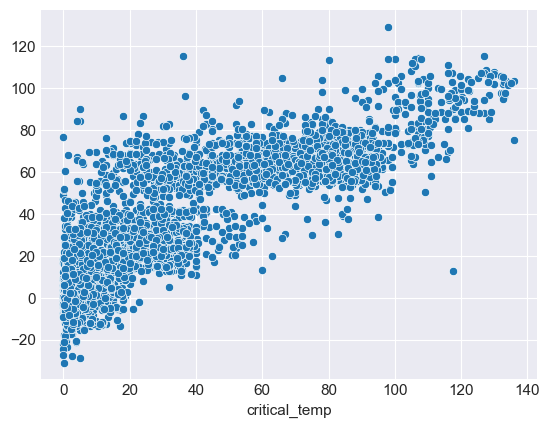

In [92]:
sns.scatterplot(x=y_test, y=df_model['y_pred'])

It does look ok! The negative temperature predictions are silly (as absolute zero is absolute) and it does look like our predictive power is worse at low critical temperatures than higher, so I do suspect that we are a bit overfit to *BaCOs. But it's a good start! It may be wise to reduce our feature selection to the top features identified in our EDA.

## Feature Selection

So our first optimization is to reduce the excessive multicollinearity of our data. PCA would be a fast and easy way to do this but I would prefer to see how far we can get without sacrificing interpretability.

In [93]:
corr_map = X.join(y).corr().abs().sort_values('critical_temp', ascending=False).drop(index='critical_temp')
corr_map.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,critical_temp
wtd_std_ThermalConductivity,0.665580,0.110856,0.350993,0.232079,0.431027,0.650085,0.684497,0.509080,0.346224,0.383254,...,0.114169,0.095745,0.115725,0.112202,0.000914,0.028360,0.014378,0.091053,0.001063,0.721271
Cu,0.588926,0.087174,0.251152,0.184049,0.308086,0.568303,0.589453,0.416408,0.287551,0.302171,...,0.083608,0.076771,0.114079,0.097523,0.071811,0.017371,0.009442,0.061220,0.004580,0.704250
range_ThermalConductivity,0.696060,0.114538,0.376573,0.243465,0.464856,0.678341,0.688968,0.548168,0.327553,0.413594,...,0.118919,0.102315,0.120852,0.112450,0.006492,0.041196,0.000940,0.094292,0.027210,0.687654
range_atomic_radius,0.768060,0.270695,0.524861,0.460197,0.645663,0.708109,0.774054,0.662463,0.433999,0.543273,...,0.166413,0.111269,0.183326,0.109200,0.122677,0.017352,0.033767,0.141498,0.001243,0.653759
std_ThermalConductivity,0.602018,0.110658,0.362512,0.233587,0.447236,0.597723,0.618855,0.502196,0.303933,0.386600,...,0.116009,0.100436,0.110293,0.113944,0.035053,0.041387,0.007160,0.099473,0.008321,0.653632
